In [3]:
#import stuff we need
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import cv2
import os
import librosa
import librosa.display
from routines import *
import warnings
warnings.filterwarnings('ignore')

In [4]:
#used for video converting
def pil_list_to_cv2(pil_list):
	#converts a list of pil images to a list of cv2 images
	png_list=[]
	for pil_img in pil_list:
		pil_img.save('trash_image.png',format='png')
		png_list.append(cv2.imread('trash_image.png'))
	os.remove('trash_image.png')
	return png_list
#generate an .avi video
def generate_video(cv2_list,path='car_race.avi',fps=10): 
	#makes a video from a given cv2 image list
	if len(cv2_list)==0:
		raise ValueError('the given png list is empty!')
	video_name = path
	frame=cv2_list[0] 
	# setting the frame width, height width 
	# the width, height of first image 
	height, width, layers = frame.shape   
	video = cv2.VideoWriter(video_name, 0, fps, (width, height))  
	# Appending the images to the video one by one 
	for cv2_image in cv2_list:  
	    video.write(cv2_image) 
	# Deallocating memories taken for window creation 
	cv2.destroyAllWindows()  
	video.release()  # releasing the video generated 

In [5]:
#calculating the acceleration of the system
def get_theta_dd(theta1,theta2,theta1_d,theta2_d,m1,m2,l1,l2,g):
	#----theta1_dd-----
	num1=-g*((2*m1+m2)*np.sin(theta1)+m2*np.sin(theta1-2*theta2))
	num2=-2*np.sin(theta1-theta2)*m2*(theta2_d**2*l2+theta1_d**2*l1*np.cos(theta1-theta2))
	denum1=2*m1+m2-m2*np.cos(2*theta1-2*theta2)
	denum=l1*denum1
	theta1_dd=(num1+num2)/denum
	#----theta2_dd----
	num1=2*np.sin(theta1-theta2)
	num2=theta1_d**2*l1*(m1+m2)+g*(m1+m2)*np.cos(theta1)+theta2_d**2*l2*m2*np.cos(theta1-theta2)
	denum=l2*denum1
	theta2_dd=num1*num2/denum
	
	return theta1_dd,theta2_dd

#calculating the systems energy
def get_energy(theta1,theta2,theta1_d,theta2_d,m1,m2,l1,l2,g):
	y1=l1*np.cos(theta1)
	y2=y1+l2*np.cos(theta2)
	e_pot=np.array([-m1*g*y1,-m2*g*y2])
	e_kin_1=m1/2*(l1*theta1_d)**2
	e_kin_2=(l1*theta1_d)**2
	e_kin_2+=(l2*theta2_d)**2
	e_kin_2+=2*l1*l2*theta1_d*theta2_d*(np.cos(theta1)*np.cos(theta2)+np.sin(theta1)*np.sin(theta2))
	e_kin_2*=m2/2
	e_kin=np.array([e_kin_1,e_kin_2])
	return e_pot,e_kin

def explicite_euler(dt,theta1,theta2,theta1_d,theta2_d,m1,m2,l1,l2,g):
	theta1_dd,theta2_dd=get_theta_dd(theta1,theta2,theta1_d,theta2_d,m1,m2,l1,l2,g)
	return theta1+dt*theta1_d,theta2+dt*theta2_d,theta1_d+dt*theta1_dd,theta2_d+dt*theta2_dd

def calculate_trajectory(n_iter,dt,theta1_init,theta2_init,theta1_d_init,theta2_d_init,m1=1,m2=1,l1=1,l2=0.5,g=10,add_energy=None):
	print('calculate phase trajectory....')
	phase_traject=np.zeros((n_iter,4))#phase-space trajectory
	phase_traject[0,:]=np.array([theta1_init,theta2_init,theta1_d_init,theta2_d_init])
	for i in range(n_iter-1):
		if i%100000==0:
			print('progress: '+str(i)+'/'+str(n_iter-1))
		if add_energy is not None:
			phase_traject[i,2]+=np.sign(phase_traject[i,2])*add_energy
		#---explicite midpoint method ----
		theta1_d_i=phase_traject[i,2]
		theta2_d_i=phase_traject[i,3]
		theta11,theta22,theta11_d,theta22_d=explicite_euler(dt/2,phase_traject[i,0],phase_traject[i,1],theta1_d_i,theta2_d_i,m1,m2,l1,l2,g)
		theta11_dd,theta22_dd=get_theta_dd(theta11,theta22,theta11_d,theta22_d,m1,m2,l1,l2,g)
		theta1_dd,theta2_dd=get_theta_dd(theta11,theta22,theta11_d,theta22_d,m1,m2,l1,l2,g)
		theta1_d=theta1_d_i+dt*theta1_dd
		theta2_d=theta2_d_i+dt*theta2_dd
		phase_traject[i+1,:]=np.array([phase_traject[i,0]+dt/2*(theta1_d_i+theta1_d),phase_traject[i,1]+dt/2*(theta2_d_i+theta2_d),theta1_d,theta2_d])
	print('done!')
	return phase_traject

def render_phase_traject(phase_traject,img_res=1,m1=1,m2=1,l1=1,l2=0.5,g=10,save_path='trash_figures/',take_frame_every=1,second_phase_traject=None):
	frames=[]
	e_pot=[]#the potential energy of each of the masses: e_pot=-m*g*y
	e_kin=[]#the kinetic energy of each of the masses: e_kin=m*l**2*theta_d**2/2
	h=int(img_res*200)
	w=2*h
	
	w_34=int(3*w/4)
	x0=int(w/4)
	y0=int(h/2)
	h_red=int(0.4*h)
	l_tot=l1+l2
	l1_ratio=l1/l_tot
	l2_ratio=l2/l_tot
	L1=l1_ratio*h_red
	L2=l2_ratio*h_red
	d=int(0.02*h)
	d1=d*m1**(1/3)
	d2=d*m2**(1/3)
	d_4=d/4
	e_pot_0,e_kin_0=get_energy(phase_traject[0,0],phase_traject[0,1],phase_traject[0,2],phase_traject[0,3],m1,m2,l1,l2,g)
	energy=np.sum(e_pot_0)+np.sum(e_kin_0)
	print('initial energy: '+str(energy))
	prev_points=[]
	prev_phase=[]
	max_points=500
	max_theta2_d=1.2*np.max(np.abs(phase_traject[:,3]))
	for i in range(phase_traject.shape[0]):
		if i%10000==0:
			print('rendering iteration: '+str(i)+'/'+str(phase_traject.shape[0]))           
		if i%take_frame_every==0:
			theta1=phase_traject[i,0]
			theta2=phase_traject[i,1]
			theta1_d=phase_traject[i,2]
			theta2_d=phase_traject[i,3]
			prev_phase.append((theta2,theta2_d))
			# theta2_d=get_corrected_theta2_d(energy,theta1,theta2,theta1_d,theta2_d,m1,m2,l1,l2,g)
			#----transform to cartesian coordinates---
			x1=x0+L1*np.sin(theta1)
			y1=y0+L1*np.cos(theta1)
			x2=x1+L2*np.sin(theta2)
			y2=y1+L2*np.cos(theta2)
			prev_points.append([np.array([x1,y1]),np.array([x2,y2])])
			#---draw the image ----
			img = Image.new("RGB", (w, h), "white")
			draw = ImageDraw.Draw(img)
			n_prev=min(max_points,len(prev_points))
			for k in range(n_prev-1):
				idx=n_prev-k
				point=prev_points[-idx]
				xx2=point[1][0]
				yy2=point[1][1]
				point=prev_points[-idx+1]
				xxx2=point[1][0]
				yyy2=point[1][1]
				intensity=int(255*(1-0.99**idx))
				draw.line([(xx2,yy2),(xxx2,yyy2)],fill=(intensity,intensity,255),width=2)
				if np.abs((prev_phase[-idx][0]+np.pi)%(2*np.pi)-(prev_phase[-idx+1][0]+np.pi)%(2*np.pi))<np.pi:
					phase_x=w_34+x0*((prev_phase[-idx][0]+np.pi)%(2*np.pi)-np.pi)/(2*np.pi)
					phase_y=y0+y0*prev_phase[-idx][1]/max_theta2_d
					phase_xx=w_34+x0*((prev_phase[-idx+1][0]+np.pi)%(2*np.pi)-np.pi)/(2*np.pi)
					phase_yy=y0+y0*prev_phase[-idx+1][1]/max_theta2_d
					draw.line([(phase_x,phase_y),(phase_xx,phase_yy)],fill=(255,intensity,intensity),width=2)
			if second_phase_traject is not None:
				x11=x0+L1*np.sin(second_phase_traject[i,0])
				y11=y0+L1*np.cos(second_phase_traject[i,0])
				x22=x11+L2*np.sin(second_phase_traject[i,1])
				y22=y11+L2*np.cos(second_phase_traject[i,1])
				draw.line([(x0,y0),(x11,y11)],fill=(255,0,0),width=1)
				draw.ellipse([(x11-d1,y11-d1),(x11+d1,y11+d1)], fill=(255,0,0), outline=None)
				draw.line([(x11,y11),(x22,y22)],fill=(255,0,0),width=1)
				draw.ellipse([(x22-d2,y22-d2),(x22+d2,y22+d2)], fill=(255,0,0), outline=None)
			draw.line([(x0,y0),(x1,y1)],fill=(0,0,0),width=1)
			draw.ellipse([(x1-d1,y1-d1),(x1+d1,y1+d1)], fill=(0,0,0), outline=None)
			draw.line([(x1,y1),(x2,y2)],fill=(0,0,0),width=1)
			draw.ellipse([(x2-d2,y2-d2),(x2+d2,y2+d2)], fill=(0,0,255), outline=None)
			frames.append(img)
			#----calculate the energies----
			e_pot_i,e_kin_i=get_energy(theta1,theta2,theta1_d,theta2_d,m1,m2,l1,l2,g)
			e_pot.append(e_pot_i)
			e_kin.append(e_kin_i)

	cv2_list=pil_list_to_cv2(frames)
	generate_video(cv2_list,path=save_path+'double_pendulum_m20.avi',fps=1000/40)

	e_pot=np.asarray(e_pot)
	e_kin=np.asarray(e_kin)
	print('final energy: '+str(np.sum(e_pot[-1,:])+np.sum(e_kin[-1,:])))
	return e_pot,e_kin

In [4]:
def render_traject_to_wave(phase_traject,img_res=1,m1=1,m2=1,l1=1,l2=0.5,g=10,save_path='trash_figures/',take_frame_every=1,frames_per_second=20,second_phase_traject=None,with_spec=False,speed=1):
	if take_frame_every<=20:
		subsampling_fac=take_frame_every
		hop_size=1
	else:
		hop_size=int(take_frame_every/20)
		take_frame_every=hop_size*20
		subsampling_fac=20
	if with_spec:
		spec=get_spectrogram(phase_traject,subsampling_fac=subsampling_fac,hop_size=hop_size,mode='outer',N=128)
		spec=np.log(spec-np.min(spec)+1)
		spec-=np.min(spec)
		spec/=np.max(spec)
	frames=[]
	h=int(img_res*200)
	w=2*h
	w_34=int(3*w/4)
	x0=int(h/2)
	y0=int(h/4)
	h_red=int(0.4*h)
	l_tot=l1+l2
	l1_ratio=l1/l_tot
	l2_ratio=l2/l_tot
	L1=l1_ratio*h_red
	L2=l2_ratio*h_red
	d=int(0.02*h)
	d1=d*m1**(1/3)
	d2=d*m2**(1/3)
	d_4=d/4
	prev_points=[]
	speed*=img_res
	h_spec=2
	for i in range(phase_traject.shape[0]):
		if i%10000==0:
			print('rendering iteration: '+str(i)+'/'+str(phase_traject.shape[0]))           
		if i%take_frame_every==0:
			theta1=phase_traject[i,0]
			theta2=phase_traject[i,1]
			theta1_d=phase_traject[i,2]
			theta2_d=phase_traject[i,3]
			#----transform to cartesian coordinates---
			x1=x0+L1*np.sin(theta1)
			y1=y0+L1*np.cos(theta1)
			x2=x1+L2*np.sin(theta2)
			y2=y1+L2*np.cos(theta2)
			prev_points.append([np.array([x1,y1]),np.array([x2,y2])])
			#---draw the image ----
			if with_spec:
				h_fac=1.5
				img=Image.new("RGB", (w, int(h_fac*h)), "white")
			else:
				img = Image.new("RGB", (w, h), "white")
			draw = ImageDraw.Draw(img)
			l=len(prev_points)
			for k in range(l-1):
				point=prev_points[k+1]
				xx2=point[1][0]
				#yy2=point[1][1]+k+1
				yy2=int(y0+L1+L2+speed*(l-(k+1)))
				point=prev_points[k]
				xxx2=point[1][0]
				#yyy2=point[1][1]+k
				yyy2=int(y0+L1+L2+speed*(l-k))
				draw.line([(yy2,xx2),(yyy2,xxx2)],fill=(0,0,255),width=2)
				if with_spec:
					for j in range(min(int((h_fac-1)*0.95*h/(h_spec*img_res)),int(1*spec.shape[0]))):  
						c=int(spec[j,k]*255)
						for step in range(yyy2-yy2):
							draw.line([(yy2+step,int(0.95*h_fac*h-h_spec*img_res*j)),(yy2+step,int(0.95*h_fac*h-h_spec*img_res*(j+1)))], fill=(c,c,c))
			draw.line([(y2,x2),(y0+L1+L2,x2)],fill=(150,150,150),width=1)               
			draw.line([(y0,x0),(y1,x1)],fill=(0,0,0),width=2)#arm
			draw.line([(y1,x1),(y2,x2)],fill=(0,0,0),width=2)
			draw.ellipse([(y1-d1,x1-d1),(y1+d1,x1+d1)], fill=(255,0,0), outline=None)
			draw.ellipse([(y2-d2,x2-d2),(y2+d2,x2+d2)], fill=(0,0,255), outline=None)
			frames.append(img)
            
	cv2_list=pil_list_to_cv2(frames)
	generate_video(cv2_list,path=save_path+'.avi',fps=frames_per_second)
	print('done!')

In [14]:
theta1_init=1*np.pi/2
theta2_init=1*np.pi/2
theta1_d_init=0
theta2_d_init=0
dt=0.005
frames_per_second=20
take_frame_every=int(1/(dt*frames_per_second))
n_iter=3000
m2=0
l2=0.8
#add_energy=5e-5
add_energy=None
phase_traject=calculate_trajectory(n_iter,dt,theta1_init,theta2_init,theta1_d_init,theta2_d_init,m2=m2,l2=l2,add_energy=add_energy)

calculate phase trajectory....
progress: 0/2999
done!


In [16]:
_,_=render_phase_traject(phase_traject,img_res=1,m1=1,m2=1,l1=1,l2=l2,g=10,save_path='trash_figures/',take_frame_every=take_frame_every,second_phase_traject=None)

initial energy: -1.7145055188062944e-15
rendering iteration: 0/3000
final energy: 55.195606277424716


In [288]:
#illustrate wave forms
wave_take_frame_every=int(2*take_frame_every)
save_path='trash_figures/dp_waveform_energy3_'+str(theta1_init)[:4]+'_'+str(theta2_init)[:4]
render_traject_to_wave(phase_traject[700000:710000],img_res=2,m1=1,m2=m2,l2=l2,g=10,save_path=save_path,with_spec=True,take_frame_every=wave_take_frame_every,frames_per_second=frames_per_second,second_phase_traject=None)

progress:1/501
progress:2/501
progress:3/501
progress:4/501
progress:5/501
progress:6/501
progress:7/501
progress:8/501
progress:9/501
progress:10/501
progress:11/501
progress:12/501
progress:13/501
progress:14/501
progress:15/501
progress:16/501
progress:17/501
progress:18/501
progress:19/501
progress:20/501
progress:21/501
progress:22/501
progress:23/501
progress:24/501
progress:25/501
progress:26/501
progress:27/501
progress:28/501
progress:29/501
progress:30/501
progress:31/501
progress:32/501
progress:33/501
progress:34/501
progress:35/501
progress:36/501
progress:37/501
progress:38/501
progress:39/501
progress:40/501
progress:41/501
progress:42/501
progress:43/501
progress:44/501
progress:45/501
progress:46/501
progress:47/501
progress:48/501
progress:49/501
progress:50/501
progress:51/501
progress:52/501
progress:53/501
progress:54/501
progress:55/501
progress:56/501
progress:57/501
progress:58/501
progress:59/501
progress:60/501
progress:61/501
progress:62/501
progress:63/501
p

rendering iteration: 0/10000
done!


evaluate the energy trajectory...


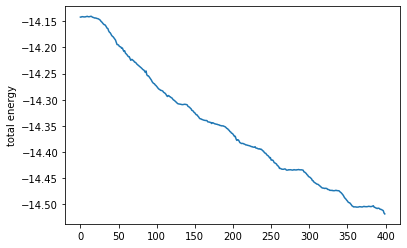

In [208]:
#plot the energy of the trajectory
total_energy=[]
print('evaluate the energy trajectory...')
calculate_every=1000
for i in range(phase_traject.shape[0]):
	if i%calculate_every==0:
		e_pot,e_kin=get_energy(phase_traject[i,0],phase_traject[i,1],phase_traject[i,2],phase_traject[i,3],m1=1,m2=m2,l1=1,l2=l2,g=10)
		total_energy.append(np.sum(e_pot,axis=0)+np.sum(e_kin,axis=0))	
plt.plot(total_energy)
plt.ylabel('total energy')
plt.show()

initial energy: -7.041719095097281e-16
rendering iteration: 0/3000
final energy: 0.08540102479928602


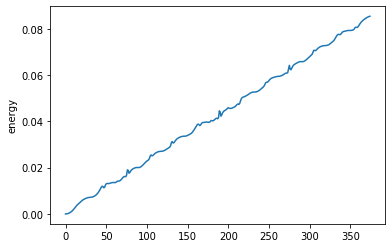

In [8]:
#render the trajectory to video
e_pot,e_kin=render_phase_traject(phase_traject[:10000],img_res=0.25,take_frame_every=int(4/dt/100),m2=m2,second_phase_traject=None)
plt.plot(np.sum(e_pot,axis=1)+np.sum(e_kin,axis=1))
plt.ylabel('energy')
plt.show()

In [117]:
def get_spectrogram(phase_traject,subsampling_fac=10,hop_size=10,mode='outer',N=256):
    if (int(np.log2(N))-np.log2(N))!=0:
        raise ValueError('the sfft size N must be a power of two!')
    samples_inner=np.sin(phase_traject[0::subsampling_fac,0])
    samples_delta=np.sin(phase_traject[0::subsampling_fac,1])
    samples_outer=samples_inner+samples_delta
    if mode=='inner':
        samples_to_render=samples_inner
    elif mode=='delta':
        samples_to_render=samples_delta
    elif mode=='outer':
        samples_to_render=samples_outer
    else:
        raise ValueError('mode must be either inner, delta or outer')
    STFT=classic_STFT(ns=hop_size,N=N)
    spec=STFT.get_energy_spec(samples_to_render)
    return spec

progress:1/1001
progress:2/1001
progress:3/1001
progress:4/1001
progress:5/1001
progress:6/1001
progress:7/1001
progress:8/1001
progress:9/1001
progress:10/1001
progress:11/1001
progress:12/1001
progress:13/1001
progress:14/1001
progress:15/1001
progress:16/1001
progress:17/1001
progress:18/1001
progress:19/1001
progress:20/1001
progress:21/1001
progress:22/1001
progress:23/1001
progress:24/1001
progress:25/1001
progress:26/1001
progress:27/1001
progress:28/1001
progress:29/1001
progress:30/1001
progress:31/1001
progress:32/1001
progress:33/1001
progress:34/1001
progress:35/1001
progress:36/1001
progress:37/1001
progress:38/1001
progress:39/1001
progress:40/1001
progress:41/1001
progress:42/1001
progress:43/1001
progress:44/1001
progress:45/1001
progress:46/1001
progress:47/1001
progress:48/1001
progress:49/1001
progress:50/1001
progress:51/1001
progress:52/1001
progress:53/1001
progress:54/1001
progress:55/1001
progress:56/1001
progress:57/1001
progress:58/1001
progress:59/1001
progre

progress:471/1001
progress:472/1001
progress:473/1001
progress:474/1001
progress:475/1001
progress:476/1001
progress:477/1001
progress:478/1001
progress:479/1001
progress:480/1001
progress:481/1001
progress:482/1001
progress:483/1001
progress:484/1001
progress:485/1001
progress:486/1001
progress:487/1001
progress:488/1001
progress:489/1001
progress:490/1001
progress:491/1001
progress:492/1001
progress:493/1001
progress:494/1001
progress:495/1001
progress:496/1001
progress:497/1001
progress:498/1001
progress:499/1001
progress:500/1001
progress:501/1001
progress:502/1001
progress:503/1001
progress:504/1001
progress:505/1001
progress:506/1001
progress:507/1001
progress:508/1001
progress:509/1001
progress:510/1001
progress:511/1001
progress:512/1001
progress:513/1001
progress:514/1001
progress:515/1001
progress:516/1001
progress:517/1001
progress:518/1001
progress:519/1001
progress:520/1001
progress:521/1001
progress:522/1001
progress:523/1001
progress:524/1001
progress:525/1001
progress:5

progress:957/1001
progress:958/1001
progress:959/1001
progress:960/1001
progress:961/1001
progress:962/1001
progress:963/1001
progress:964/1001
progress:965/1001
progress:966/1001
progress:967/1001
progress:968/1001
progress:969/1001
progress:970/1001
progress:971/1001
progress:972/1001
progress:973/1001
progress:974/1001
progress:975/1001
progress:976/1001
progress:977/1001
progress:978/1001
progress:979/1001
progress:980/1001
progress:981/1001
progress:982/1001
progress:983/1001
progress:984/1001
progress:985/1001
progress:986/1001
progress:987/1001
progress:988/1001
progress:989/1001
progress:990/1001
progress:991/1001
progress:992/1001
progress:993/1001
progress:994/1001
progress:995/1001
progress:996/1001
progress:997/1001
progress:998/1001
progress:999/1001
progress:1000/1001
progress:1001/1001
(129, 1001)


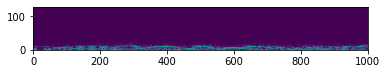

In [118]:
spec=get_spectrogram(phase_traject,mode='outer')
print(spec.shape)
plt.imshow(np.log(spec+1),origin='lower')
plt.show()

In [6]:
def fade_samples(samples):
    n_fade=20
    for i in range(n_fade):
        samples[i]=i/n_fade*samples[i]
        samples[-i-1]=i/n_fade*samples[-i-1]
    return samples

# render_phase_traject(phase_traject,img_res=0.5,take_frame_every=int(2/dt/100),m2=m2)
samples_inner=np.sin(phase_traject[0::10,0])
samples_delta=np.sin(phase_traject[0::10,1])
samples_outer=samples_inner+samples_delta

samples_to_render=samples_outer[:150000]
samples_to_render=fade_samples(samples_to_render)
print(samples_to_render.shape)
fs=6000
librosa.output.write_wav('trash_figures/doublependulum_sound_'+str(theta1_init)[:4]+'_'+str(theta2_init)[:4]+'.mp3', samples_to_render, fs,norm=True)


(100000,)


progress:1/334
progress:2/334
progress:3/334
progress:4/334
progress:5/334
progress:6/334
progress:7/334
progress:8/334
progress:9/334
progress:10/334
progress:11/334
progress:12/334
progress:13/334
progress:14/334
progress:15/334
progress:16/334
progress:17/334
progress:18/334
progress:19/334
progress:20/334
progress:21/334
progress:22/334
progress:23/334
progress:24/334
progress:25/334
progress:26/334
progress:27/334
progress:28/334
progress:29/334
progress:30/334
progress:31/334
progress:32/334
progress:33/334
progress:34/334
progress:35/334
progress:36/334
progress:37/334
progress:38/334
progress:39/334
progress:40/334
progress:41/334
progress:42/334
progress:43/334
progress:44/334
progress:45/334
progress:46/334
progress:47/334
progress:48/334
progress:49/334
progress:50/334
progress:51/334
progress:52/334
progress:53/334
progress:54/334
progress:55/334
progress:56/334
progress:57/334
progress:58/334
progress:59/334
progress:60/334
progress:61/334
progress:62/334
progress:63/334
p

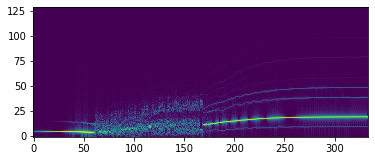

In [8]:
#show spec
time_step=0.05#ms
ns=time_step*fs
STFT=classic_STFT(ns=ns,N=256)
spec=STFT.get_energy_spec(samples_to_render)
plt.imshow(np.log(spec+1),origin='lower')
plt.savefig('trash_figures/doublependulum_spec_'+str(theta1_init)[:4]+'_'+str(theta2_init)[:4]+'.png', format='png', dpi=500) 
plt.show()
